Here I will aim to compute the sex-linkage of each chromosome, by mapping RADtags to the ordered Rtemp genome. The steps are as follows:


1. For a given vcf, get the sequences for each tag
2. Map these sequences to the ordered Rtemp genome
3. Retrieve the male vs female statistics for each chromosome separately
4. Compare these as a measure of the likelihood that each chromosome is sex linked. 

In [146]:
%matplotlib inline
from __future__ import division
import MISC_RAD_tools as MISC
import numpy as np
from Bio.Blast.Applications import NcbiblastnCommandline
from matplotlib import pyplot as plt
import vcf

### Step 1. Get tags from a vcf file. 

In [2]:
help(MISC.fasta_maka)

Help on function fasta_maka in module MISC_RAD_tools:

fasta_maka(whitey, cat, out=None)
    whitey = whitelist (either a python list or a file path) containing locus IDs in the form of "<Tag_ID>_<Position>"
    cat    = path to the catalog file to get sequences from



In [9]:
R_ibe_VCF = open("/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Populations_N_spain/batch_1.vcf", 'r').readlines()
catalog = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/batch_1.catalog.tags.tsv.gz"

tags = []

for line in R_ibe_VCF:
    if not line.startswith("#"):
        tag_ID = line.split()[2]
        if tag_ID not in tags:
            tags.append(tag_ID)
            
MISC.fasta_maka(tags, catalog)

### Step 2. map these to the genome

In [202]:
tag_fasta_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Populations_N_spain/vcf_tags.fa"
Rtemp_Genome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
Rtemp_Genome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
blast_out_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Populations_N_spain/vcf_tags_bastouts.xml"

best_hit_crit = 1e-10
Eval_threshold = 1e-30
Window = 2000
threads = 7

In [203]:
blastn_cline = NcbiblastnCommandline(query=tag_fasta_path, db=Rtemp_Genome_db, outfmt=5, out=blast_out_path, num_threads=threads)
stdout, stderr = blastn_cline()

blastn_out_records = MISC.BlastParseExtra(blast_out_path, Rtemp_Genome_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 65
Number of unique alingments kept: 114


In [38]:
Xen_chroms = {}

Xen_chroms["Chr01"] = []
Xen_chroms["Chr02"] = []
Xen_chroms["Chr03"] = []
Xen_chroms["Chr04"] = []
Xen_chroms["Chr05"] = []
Xen_chroms["Chr06"] = []
Xen_chroms["Chr07"] = []
Xen_chroms["Chr08"] = []
Xen_chroms["Chr09"] = []
Xen_chroms["Chr10"] = []


for tag in blastn_out_records:
    ref_hit_chrom = blastn_out_records[tag]["Ref_hit_id"].split("_")[1]
    if ref_hit_chrom in Xen_chroms:
        Xen_chroms[ref_hit_chrom].append(tag)
        
for i in sorted(Xen_chroms.keys()):
    print "N tags on %s = %s" % (i, len(Xen_chroms[i]))
print "\nTotal tags mapped = %s" % np.sum([len(i) for i in Xen_chroms.values()])

N tags on Chr01 = 115
N tags on Chr02 = 42
N tags on Chr03 = 78
N tags on Chr04 = 60
N tags on Chr05 = 39
N tags on Chr06 = 43
N tags on Chr07 = 58
N tags on Chr08 = 36
N tags on Chr09 = 28
N tags on Chr10 = 24

Total tags mapped = 523


### Step 3. Get the male and female fstats for these loci

In [183]:
sumstats = open("/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Populations_N_spain/batch_1.sumstats.tsv", 'r').readlines()

heterozygosities = {}

for i in sumstats:
    if not i.startswith("#"):
        SNP_tag_ID = i.split()[1]
        SNP_pos = i.split()[3]
        ID = "%s_%s" % (SNP_tag_ID, SNP_pos)
        pop = i.split()[5]
        
        if pop not in heterozygosities:
            heterozygosities[pop] = {}
        
        heterozygosities[pop][ID] = float(i.split()[10])

#heterozygosities

In [182]:
heterozygosities_filtered = {}
heterozygosities_filtered["M"] = {}
heterozygosities_filtered["F"] = {}

for tag in heterozygosities["M"]:
    if not heterozygosities["M"][tag] + heterozygosities["F"][tag] >= 1.5:
        heterozygosities_filtered["M"][tag] = heterozygosities["M"][tag]
        heterozygosities_filtered["F"][tag] = heterozygosities["F"][tag]

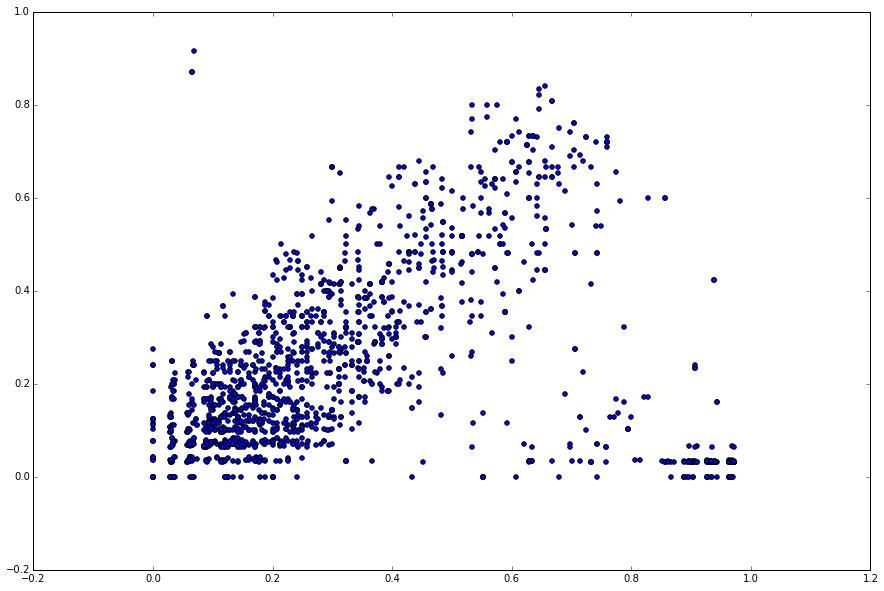

In [195]:
fig = plt.figure(figsize=(15,10))
plt.scatter(heterozygosities_filtered["M"].values(), heterozygosities_filtered["F"].values())

plt.show()

Ok, so this looks pretty good. I know there are a lot of TEs left in this dataset, as I didn't filter for max_obs_het. So you can see a lot of loci at 1/1 (x/y) which are heterozygous in almost all samples.

*** Now filtered these TEs out

You can then see lots of loci that are no very heterozygous at around 0/0. 

And the putitatively sex linked markers are those at 1/0 (males are on the x here, and females on the y). So we need the location of these. So find a nice way to plot this! 

In [199]:
Male_minus_Female_hets_per_chrom = {}

Male_minus_Female_hets_per_chrom["Chr01"] = []
Male_minus_Female_hets_per_chrom["Chr02"] = []
Male_minus_Female_hets_per_chrom["Chr03"] = []
Male_minus_Female_hets_per_chrom["Chr04"] = []
Male_minus_Female_hets_per_chrom["Chr05"] = []
Male_minus_Female_hets_per_chrom["Chr06"] = []
Male_minus_Female_hets_per_chrom["Chr07"] = []
Male_minus_Female_hets_per_chrom["Chr08"] = []
Male_minus_Female_hets_per_chrom["Chr09"] = []
Male_minus_Female_hets_per_chrom["Chr10"] = []

for tag in heterozygosities_filtered["M"]:
    for chrom in Xen_chroms:
        if tag.split("_")[0] in Xen_chroms[chrom]:
            Male_minus_Female_hets_per_chrom[chrom].append(heterozygosities_filtered["M"][tag] - heterozygosities_filtered["F"][tag])
            print heterozygosities_filtered["M"][tag], heterozygosities_filtered["F"][tag], heterozygosities_filtered["M"][tag] - heterozygosities_filtered["F"][tag]


0.2258 0.1111 0.1147
0.0667 0.0769 -0.0102
0.4688 0.44 0.0288
0.3667 0.3462 0.0205
0.4516 0.0323 0.4193
0.3939 0.3214 0.0725
0.1935 0.3704 -0.1769
0.6286 0.6 0.0286
0.9 0.0323 0.8677
0.6429 0.6 0.0429
0.3448 0.2308 0.114
0.3429 0.2903 0.0526
0.3824 0.4194 -0.037
0.3 0.1429 0.1571
0.2857 0.3548 -0.0691
0.1515 0.0741 0.0774
0.0 0.0 0.0
0.9032 0.0323 0.8709
0.0625 0.0345 0.028
0.2353 0.4839 -0.2486
0.1429 0.1724 -0.0295
0.1481 0.1724 -0.0243
0.7941 0.1034 0.6907
0.1875 0.08 0.1075
0.9355 0.0645 0.871
0.069 0.0714 -0.0024
0.1724 0.0385 0.1339
0.2424 0.4444 -0.202
0.2258 0.04 0.1858
0.3429 0.2903 0.0526
0.3429 0.2903 0.0526
0.3793 0.2308 0.1485
0.3429 0.2903 0.0526
0.3429 0.2903 0.0526
0.3824 0.4194 -0.037
0.9643 0.0 0.9643
0.1379 0.1379 0.0
0.4444 0.1923 0.2521
0.0645 0.069 -0.0045
0.0312 0.1724 -0.1412
0.2121 0.0714 0.1407
0.9032 0.0323 0.8709
0.0588 0.1379 -0.0791
0.0968 0.25 -0.1532
0.9714 0.0323 0.9391
0.3793 0.3077 0.0716
0.6 0.25 0.35
0.4444 0.2222 0.2222
0.0882 0.0645 0.0237
0.069 0

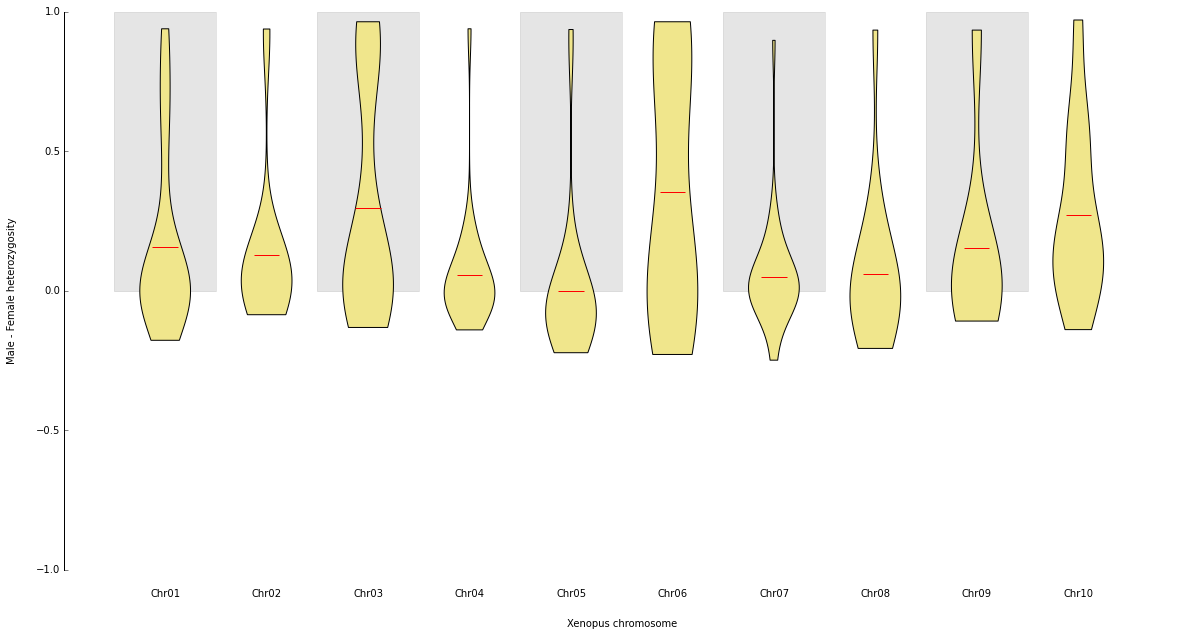

In [200]:
# And now then I just need to plot this as box plots

fig = plt.figure(figsize=(20,10), frameon = False, edgecolor = 'none')
ax = plt.subplot(111)
pos = 1
col = "white"

max_y = 1

for i in sorted(Male_minus_Female_hets_per_chrom.keys()):

        if col == "grey":
            col = "white"
        elif col == "white":
            col = "grey"
        
        ax.bar(left = pos-0.5, width = 1, height= max_y, color= col, edgecolor = col, bottom = 0, alpha = 0.2, zorder = 1)
        #ax.scatter([pos]*(len(Male_minus_Female_hets_per_chrom[i])), Male_minus_Female_hets_per_chrom[i])
        vio = ax.violinplot(Male_minus_Female_hets_per_chrom[i], positions=[pos], showmeans = True, showextrema = False )
        
        for pc in vio['bodies']:
            pc.set_facecolor('khaki')
            pc.set_edgecolor('black')
            pc.set_zorder(2)    
            pc.set_alpha(1)
        
        pos += 1

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left spines
ax.yaxis.set_ticks_position('left')

ax.set_xlim(0, 11)
ax.set_ylim(-1, 1)
ax.set_xticks(range(1,11))
ax.set_xticklabels(sorted(Male_minus_Female_hets_per_chrom.keys()))
ax.set_xlabel("Xenopus chromosome", labelpad=20)
ax.set_ylabel("Male - Female heterozygosity",labelpad=20)
ax.get_xaxis().set_tick_params(which='both', direction='out', pad = 15, bottom = 'off', top = 'off')
#plt.title(Species)

#plt.savefig("%s/Per_chromosome_mappings.svg" %  sex_linked_markers_path.rpartition("/")[0])
    
plt.show()

So this isn't as clean as I would have liked. . . Chr03 does indeed look like the most likely candidate, but if it is this noisy in iberica, then it will be useless in species where the data is more ambiguous. . . . 

So Instead, I will count the number of heterozygous and homozygous loci per sample and plot this for each chromosome. . . . so back to VCF and pyVCF

In [162]:
record.heterozygosity

0.49984610649430594

In [196]:
Per_chrom_and_sample_dict = {}

for chrom in Xen_chroms:
    print "Processing chromosom:", chrom
    if chrom not in Per_chrom_and_sample_dict:
        Per_chrom_and_sample_dict[chrom] = {}
    
    vcfhandle = open("/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Populations_N_spain/batch_1.vcf.altered", 'r')
    myvcf = vcf.Reader(vcfhandle)
        
    for record in myvcf:
        if record.heterozygosity < 2 and record.aaf > 0.1: ## take out repeats and rare alleles
            if record.ID in Xen_chroms[chrom]:
                for sample in record.samples:
                    if sample.sample not in Per_chrom_and_sample_dict[chrom]:
                        Per_chrom_and_sample_dict[chrom][sample.sample] = {}
                        Per_chrom_and_sample_dict[chrom][sample.sample]["het"] = 0
                        Per_chrom_and_sample_dict[chrom][sample.sample]["total"] = 0

                    if not sample.is_het == None:
                        Per_chrom_and_sample_dict[chrom][sample.sample]["total"] += 1
                    if sample.is_het:
                        Per_chrom_and_sample_dict[chrom][sample.sample]["het"] += 1

Processing chromosom: Chr10
Processing chromosom: Chr08
Processing chromosom: Chr09
Processing chromosom: Chr04
Processing chromosom: Chr05
Processing chromosom: Chr06
Processing chromosom: Chr07
Processing chromosom: Chr01
Processing chromosom: Chr02
Processing chromosom: Chr03


In [197]:
Per_chrom_and_sample_proportions = {}

for chrom in Per_chrom_and_sample_dict:
    if chrom not in Per_chrom_and_sample_proportions:
        Per_chrom_and_sample_proportions[chrom] = {}
    for sample in Per_chrom_and_sample_dict[chrom]:
        Per_chrom_and_sample_proportions[chrom][sample] = Per_chrom_and_sample_dict[chrom][sample]["het"]/Per_chrom_and_sample_dict[chrom][sample]["total"]

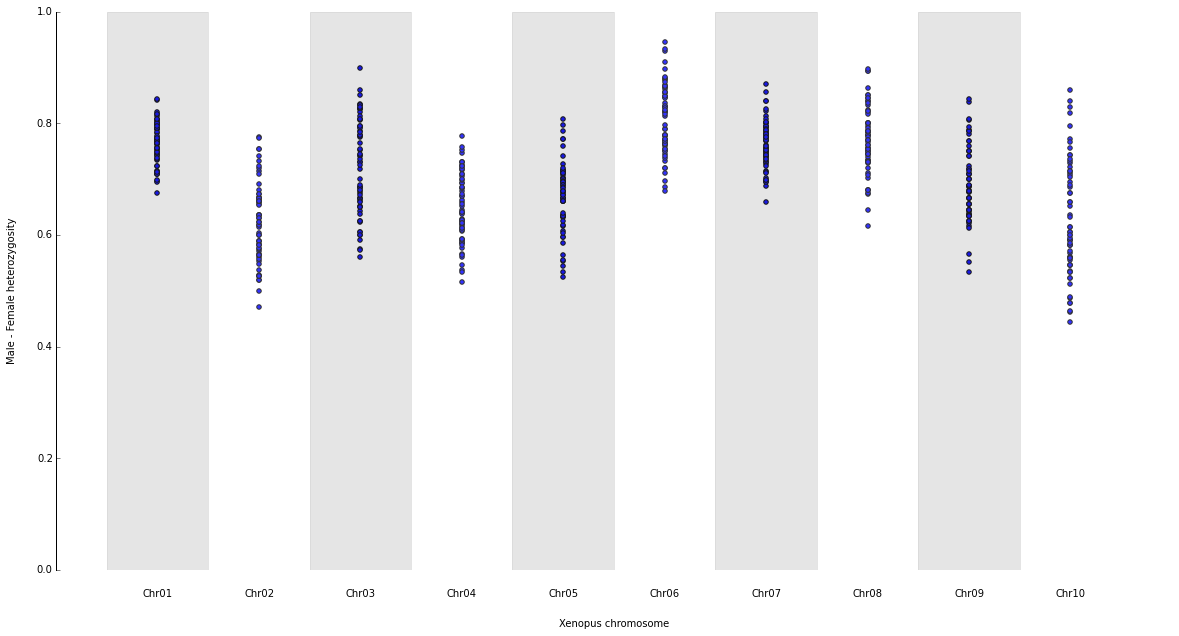

In [198]:
# And now then I just need to plot this as box plots

fig = plt.figure(figsize=(20,10), frameon = False, edgecolor = 'none')
ax = plt.subplot(111)
pos = 1
col = "white"

max_y = 1

for i in sorted(Per_chrom_and_sample_proportions.keys()):

        if col == "grey":
            col = "white"
        elif col == "white":
            col = "grey"
        
        ax.bar(left = pos-0.5, width = 1, height= max_y, color= col, edgecolor = col, bottom = 0, alpha = 0.2, zorder = 1)
        ax.scatter([pos]*(len(Per_chrom_and_sample_proportions[i].values())), Per_chrom_and_sample_proportions[i].values())
        #vio = ax.violinplot(Per_chrom_and_sample_proportions[i].values(), positions=[pos], showmeans = True, showextrema = False )
        
        for pc in vio['bodies']:
            pc.set_facecolor('khaki')
            pc.set_edgecolor('black')
            pc.set_zorder(2)    
            pc.set_alpha(1)
        
        pos += 1

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left spines
ax.yaxis.set_ticks_position('left')

ax.set_xlim(0, 11)
ax.set_ylim(0, 1)
ax.set_xticks(range(1,11))
ax.set_xticklabels(sorted(Per_chrom_and_sample_proportions.keys()))
ax.set_xlabel("Xenopus chromosome", labelpad=20)
ax.set_ylabel("Male - Female heterozygosity",labelpad=20)
ax.get_xaxis().set_tick_params(which='both', direction='out', pad = 15, bottom = 'off', top = 'off')
#plt.title(Species)

#plt.savefig("%s/Per_chromosome_mappings.svg" %  sex_linked_markers_path.rpartition("/")[0])
    
plt.show()

Still no pattern - what is going on here. . . . Maybe its the mapping then . . . See where the tags that were on that scatter plot fall in terms of the mapping. . . 

In [174]:
Xen_chrom_colour_dict = {}

Xen_chrom_colour_dict["Chr01"] = "black"
Xen_chrom_colour_dict["Chr02"] = "grey"
Xen_chrom_colour_dict["Chr03"] = "firebrick"
Xen_chrom_colour_dict["Chr04"] = "chocolate"
Xen_chrom_colour_dict["Chr05"] = "gold"
Xen_chrom_colour_dict["Chr06"] = "green"
Xen_chrom_colour_dict["Chr07"] = "darksage"
Xen_chrom_colour_dict["Chr08"] = "turquoise"
Xen_chrom_colour_dict["Chr09"] = "dodgerblue"
Xen_chrom_colour_dict["Chr10"] = "purple"

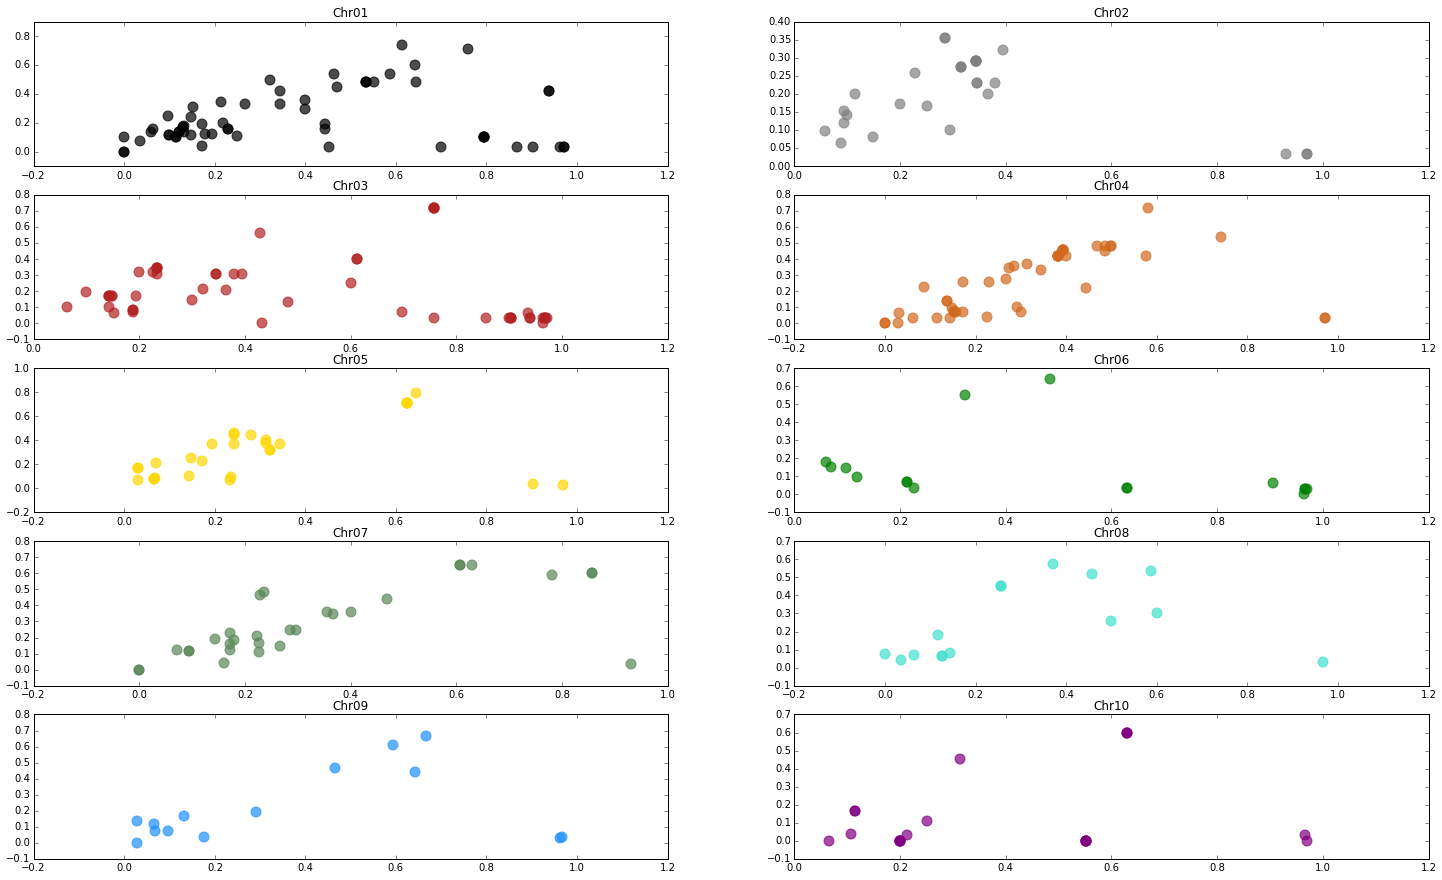

In [194]:

fig = plt.figure(figsize=(25,15))
pos = 1
for Chrom in sorted(Xen_chroms.keys()):
    fig.add_subplot(5,2,pos)
    for tag in heterozygosities_filtered["M"]:
        if tag.split("_")[0] in Xen_chroms[Chrom]:

            plt.scatter(heterozygosities_filtered["M"][tag], heterozygosities_filtered["F"][tag], color = Xen_chrom_colour_dict[Chrom], s = 100, alpha=0.7)
            plt.title(Chrom)
    pos += 1


plt.show()


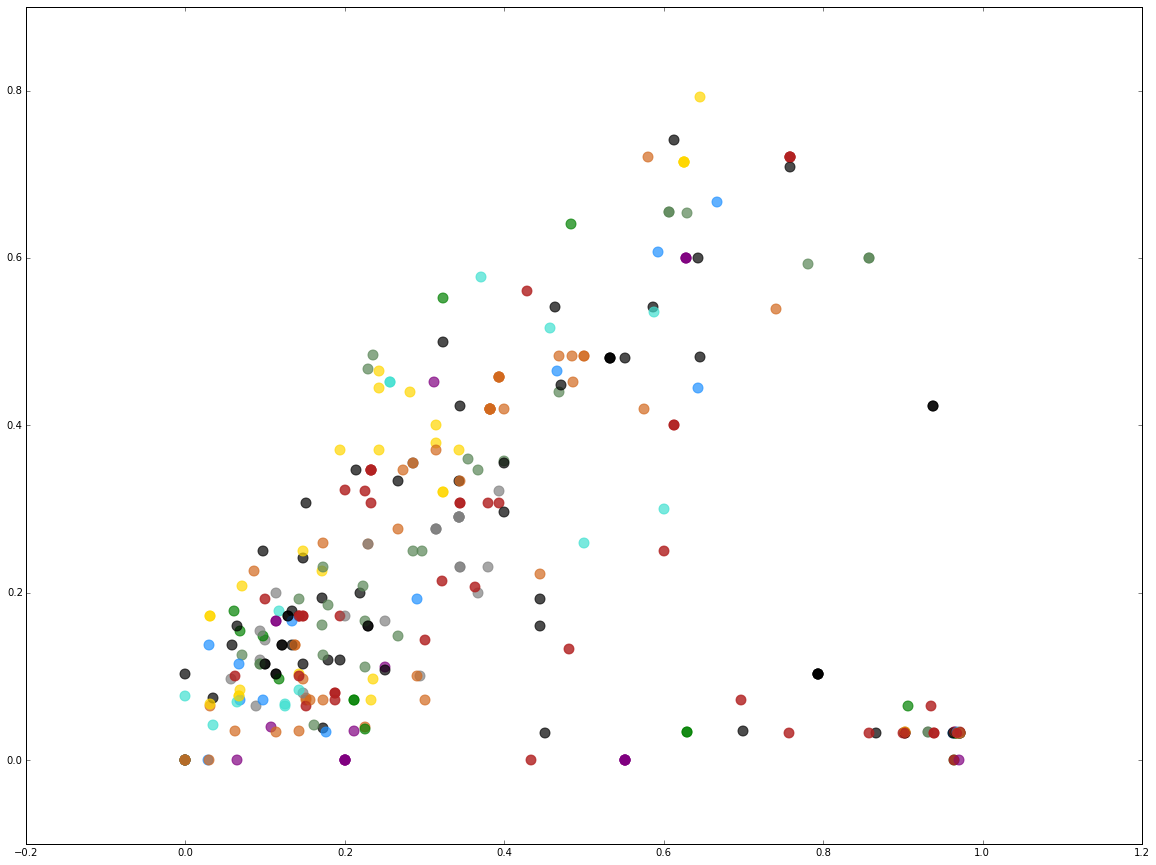

In [201]:

fig = plt.figure(figsize=(20,15))

for tag in heterozygosities_filtered["M"]:
    
    for Chrom in Xen_chroms:
        if tag.split("_")[0] in Xen_chroms[Chrom]:

            plt.scatter(heterozygosities_filtered["M"][tag], heterozygosities_filtered["F"][tag], color = Xen_chrom_colour_dict[Chrom], s = 100, alpha=0.7)
    
### plot the Chr03 on top to see what happens
for tag in heterozygosities_filtered["M"]:
    if tag.split("_")[0] in Xen_chroms["Chr03"]:
        plt.scatter(heterozygosities_filtered["M"][tag], heterozygosities_filtered["F"][tag], color = Xen_chrom_colour_dict[Chrom], s = 80, alpha=0.4)


plt.show()

            

So it seems like the problem is the mis-mapping to the genome in the first place - if indeed the loci in the bottom right are sex linked, then they should all map to the third chromosome. However these loci map to severl chromosomes, and although the highest number map to Chr03, there are a lot that map elsewhere. So this is not going to be a viable option for other species, given that iberica have the most sex linked markers and are closest in terms of time since divergence. Hopefully the new genome will help with this for the iberica project. 